# Problem Set 4 
# Support Vector Machines

In this problem set you will implement an SVM and fit it using quadratic programming. We will use the CVXOPT module to solve the optimization problems. 

### Quadratic Programming (QP)

The standard form of a QP can be formulated as 
$$
\begin{align}
\min_x\quad &\frac12 x^TPx + q^Tx\\
\text{subject to }\quad & Gx \preceq h\\
& Ax = b
\end{align}
$$
where $\preceq$ is an element-wise $\leq$.
CVXOPT solver finds an optimal solution $x^*$, given a set of matrices $P, q, G, h, A, b$.

FYI, you can read on the methods to solve quadratic programming problems [here](https://en.wikipedia.org/wiki/Quadratic_programming#Solution_methods).

## Problem 1 (10 points)

Design appropriate matrices to solve the following problem.
$$
\begin{align}
\min_x\quad &f(x)=x_1^2 + 4x_2^2-8x_1-16x_2\\
\text{subject to }\quad & x_1+x_2\leq 5\\
& x_1 \leq 3\\
& x_2 \geq 0
\end{align}
$$

You might need to run this command on the Anaconda terminal: 
#### pip install cvxopt

In [1]:
from cvxopt import matrix, solvers
# Turns off the printing of CVXOPT solution for the rest of the notebook
solvers.options['show_progress'] = False

P = 2 * matrix([[1., 0.], [0., 4.]])
#------------------------------------------------------------------------------------------
# Define q, G, h
# Hint: the x vector is 2x1
#raise NotImplementedError('Construct the appropriate matrices.')
q = matrix([-8.0, -16.0])
G = matrix([[1.0,1.0,0.0],[1.0,0.0,-1.0]])
h = matrix([5.0, 3.,0.])
#------------------------------------------------------------------------------------------

sol = solvers.qp(P, q, G, h)
x1, x2 = sol['x']
print('Optimal x: ({:.8f}, {:.8f})'.format(x1, x2))

Optimal x: (2.99999993, 1.99927914)


Let's visualize the solution

C:\Users\piyus\AppData\Local\Temp/ipykernel_21276/40706664.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2, F, cmap='jet')


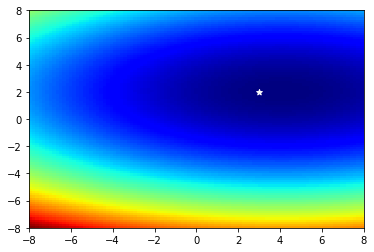

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

X1, X2 = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
F = X1**2 + 4*X2**2 - 8*X1 - 16 * X2

plt.pcolor(X1, X2, F, cmap='jet')
plt.scatter([x1], [x2], marker='*', color='white')
plt.show()

### Linear SVM

Now, let's implement linear SVM. We will do this for a general case, that allows class distributions to overlap.

As a linear model, linear SVM produces classification scores for a given sample $x$ as
$$
 \hat y(x) = w^T\phi(x) + b
$$
where $w\in\mathbb{R}^d$, $b\in\mathbb{R}$ are model weights and bias, respectively, and $\phi$ is a fixed feature-space transformation. Final label prediction is done by taking the sign of $\hat y(x)$.

Given a set of training samples $x_n\in\mathbb{R}^d$, $n\in 1,\ldots, N$, with the corresponding labels $y_i\in\{-1, 1\}$ linear SVM is fit (*i.e.* parameters $w$ and $b$ are chosen) by solving the following constrained optimization task:
$$
\begin{align}
    \min_{w, \xi, b}\quad & \frac12||w||^2 + C\sum_{n=1}^N \xi_n\\
    \text{subject to }\quad & y_n\hat y(x_n) \geq 1 - \xi_n, & n=1,\ldots, N\\
    & \xi_n \geq 0, & n=1,\ldots, N
\end{align}
$$

## Problem 2 (40 points)
## 2.1 [30 pts]
Your task is to implement this using a QP solver by designing appropriate matrices $P$, $q$, $G$, $h$.

##### Hints
1. You need to optimize over $w, \xi, b$. You can simply concatenate them into $\chi = (w, \xi, b)$ to feed it into QP-solver. Now, how to define the objective function and the constraints in terms of $\chi$? (For example, $b_1 + b_2$ can be obtained from vector $(a_1, b_1, b_2, c_1, c_2)$ by taking the inner product with $(0, 1, 1, 0, 0)$).
3. You can use `np.bmat` to construct matrices. Like this:

In [21]:
np.bmat([[np.identity(3), np.zeros((3, 1))],
         [np.zeros((2, 3)), -np.ones((2, 1))]])

matrix([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.]])

In [25]:
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator
from matplotlib import pyplot as plt
import numpy as np

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, Y):
        """Fit Linear SVM using training dataset (X, Y).
        
        :param X: data samples of shape (N, d).
        :param Y: data target labels of size (N). Each label is either 1 or -1.
        """
        # Apply transformation (phi) to X
        if self.transform is not None:
            X = self.transform(X)
        d = len(X[0])
        N = len(X)
        
        
        #------------------------------------------------------------------------------------------
        # Construct appropriate matrices here to solve the optimization problem described above.
        # We want optimal solution for vector (w, xi, b). 
        #raise NotImplementedError('Construct the appropriate matrices.')
        P = matrix(np.bmat([[np.identity(d), np.zeros((d, N + 1))],
                            [np.zeros((N + 1, d)), np.zeros((N + 1, N + 1))]]))
        q = matrix([0.] * d + [self.C] * N + [0])
        G = matrix(np.bmat([[-np.dot(np.diag(Y), X), -np.identity(N), -np.array(Y).reshape((N, 1))],
                            [np.zeros((N,d)), -np.identity(N), np.zeros((N, 1))]]))

        h = matrix([-1.] * N + [0.] * N)
        #------------------------------------------------------------------------------------------
        
        #sol = solvers.qp(P, q, G, h)
        sol = solvers.qp(P, q, G, h, kktsolver='ldl', options={'kktreg':1e-9})
        ans = np.array(sol['x']).flatten()
        self.weights_ = ans[:d]
        self.xi_ = ans[d:d+N]
        self.bias_ = ans[-1]
        
        # Find support vectors. A boolean array of length N having True for support
        # vectors and False for the rest.
        margin = Y * (X.dot(model.weights_) + self.bias_)
        self.support_vectors = np.isclose(margin,  1 - self.xi_)
        
    def predict_proba(self, X):
        """
        Make real-valued prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N predicted scores.
        """
        #------------------------------------------------------------------------------------------
        # return y_hat
        #raise NotImplementedError('Return y_hat.')
        if self.transform is not None: 
            X = self.transform(X)
        return np.dot(X, self.weights_)+ self.bias_

        #------------------------------------------------------------------------------------------

    def predict(self, X):
        """
        Make binary prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N binary predicted labels from {-1, 1}.
        """
        return np.sign(self.predict_proba(X))

Let's see how our LinearSVM performs on some data.

In [23]:
from sklearn.datasets import make_classification, make_circles
X = [None, None, None]
y = [None, None, None]
X[0], y[0] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
X[1], y[1] = make_circles(n_samples=100, factor=0.5)
X[2], y[2] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=4)

# Go from {0, 1} to {-1, 1}
y = [2 * yy - 1 for yy in y]

     pcost       dcost       gap    pres   dres
 0:  4.4110e-01  4.7209e+00  3e+02  2e+00  1e+02
 1:  1.7239e+00 -4.8847e+00  7e+00  3e-02  2e+00
 2:  1.2656e+00  4.3976e-01  8e-01  1e-15  4e-16
 3:  5.8860e-01  4.6472e-01  1e-01  4e-16  5e-17
 4:  5.2768e-01  4.9322e-01  3e-02  2e-16  6e-17
 5:  5.1223e-01  5.0334e-01  9e-03  2e-16  1e-16
 6:  5.0768e-01  5.0639e-01  1e-03  2e-16  2e-16
 7:  5.0703e-01  5.0688e-01  1e-04  2e-16  1e-16
 8:  5.0695e-01  5.0694e-01  4e-06  2e-16  4e-17
 9:  5.0694e-01  5.0694e-01  2e-07  2e-16  2e-16
Optimal solution found.


C:\Users\piyus\AppData\Local\Temp/ipykernel_4112/924786700.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


     pcost       dcost       gap    pres   dres
 0:  4.9500e-01  5.1995e+01  4e+02  2e+00  3e+01
 1:  1.9800e+00 -2.3498e+00  4e+00  2e-02  2e-01
 2:  1.4225e+00  8.4919e-01  6e-01  6e-16  1e-16
 3:  1.0042e+00  9.8193e-01  2e-02  3e-16  7e-17
 4:  1.0000e+00  9.9982e-01  2e-04  6e-16  4e-17
 5:  1.0000e+00  1.0000e+00  2e-06  6e-16  3e-17
 6:  1.0000e+00  1.0000e+00  2e-08  6e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.6006e-01  2.4444e+01  6e+02  3e+00  2e+02
 1:  2.1379e+00 -5.6075e+00  8e+00  3e-02  2e+00
 2:  1.5092e+00  4.9224e-01  1e+00  2e-15  6e-16
 3:  6.8761e-01  5.6507e-01  1e-01  5e-16  1e-16


C:\Users\piyus\AppData\Local\Temp/ipykernel_4112/924786700.py:26: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')


 4:  6.3981e-01  6.2145e-01  2e-02  4e-16  4e-17
 5:  6.3356e-01  6.2988e-01  4e-03  4e-16  1e-16
 6:  6.3210e-01  6.3187e-01  2e-04  3e-16  1e-16
 7:  6.3200e-01  6.3200e-01  4e-06  3e-16  1e-16
 8:  6.3200e-01  6.3200e-01  4e-08  4e-16  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.4513e-02  1.6819e+01  4e+02  2e+00  1e+02
 1:  1.2121e+01 -1.1000e+01  2e+01  7e-02  5e+00
 2:  3.4631e+00  5.6130e-01  3e+00  2e-15  1e-15
 3:  1.5436e+00  7.9553e-01  7e-01  7e-16  6e-16
 4:  1.2675e+00  9.0724e-01  4e-01  4e-16  5e-16
 5:  1.1092e+00  9.9208e-01  1e-01  2e-16  3e-16
 6:  1.0609e+00  1.0194e+00  4e-02  2e-16  2e-16
 7:  1.0402e+00  1.0315e+00  9e-03  2e-16  4e-16
 8:  1.0353e+00  1.0347e+00  6e-04  3e-16  3e-16
 9:  1.0350e+00  1.0350e+00  7e-06  2e-16  2e-16
10:  1.0350e+00  1.0350e+00  7e-08  3e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.5000e+00  6.9500e+01  4e+02  2e+00  3e+01
 1:  1.9215e+01  8.0310

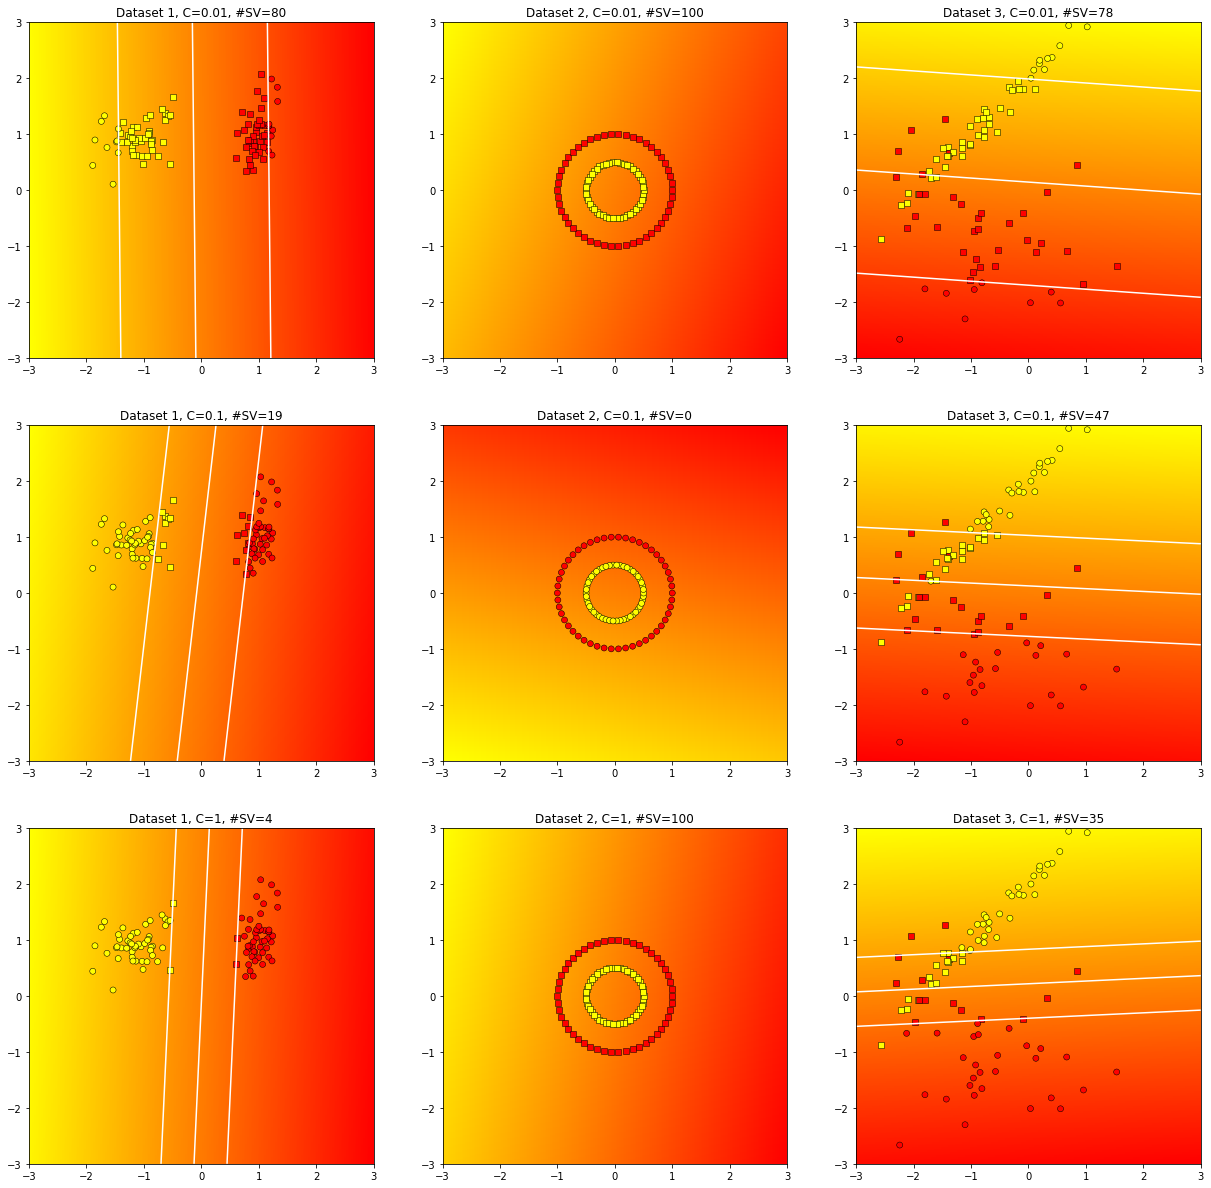

In [24]:
C_values = [0.01, 0.1, 1]

plot_i = 0
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

Why does the number of support vectors decrease as $C$ increases?

For debug purposes. Very last model must have almost the same weights and bias:
$$w = \begin{pmatrix}-0.0784521\\ 1.62264867\end{pmatrix}$$
$$b = -0.3528510092782581$$

In [17]:
model.weights_

array([-0.0784521 ,  1.62264867])

In [18]:
model.bias_

-0.35285100927825713

## 2.2 [10 pts]

Even using a linear SVM, we are able to separate data that is linearly inseparable by using feature transformation.

Implement the following feature transformation
$
    \phi(x_1, x_2) = (x_1,\ x_2,\ x_1^2,\ x_2^2,\ x_1x_2)
$

In [19]:
def append_second_order(X):
    """Given array Nx[x1, x2] return Nx[x1, x2, x1^2, x2^2, x1x2]."""
    #------------------------------------------------------------------------------------------
    # return new_X
    #raise NotImplementedError('Return new_X.')
    return np.concatenate((X, X * X, (X[:, :1] * X[:, 1:])), axis = 1)
    #------------------------------------------------------------------------------------------

assert np.all(append_second_order(np.array([[1, 2]])) == np.array([[1, 2, 1, 4, 2]])), 'Transformation is incorrect.'

     pcost       dcost       gap    pres   dres
 0:  4.1992e-01  3.6296e+00  3e+02  2e+00  2e+02
 1:  1.5116e+00 -1.2316e+01  1e+01  8e-02  8e+00
 2:  1.3091e+00  1.5530e-01  1e+00  9e-04  1e-01
 3:  4.2663e-01  3.0275e-01  1e-01  1e-04  1e-02
 4:  3.6631e-01  3.3918e-01  3e-02  1e-05  1e-03
 5:  3.5316e-01  3.4939e-01  4e-03  1e-06  1e-04
 6:  3.5164e-01  3.5052e-01  1e-03  2e-07  2e-05
 7:  3.5116e-01  3.5093e-01  2e-04  4e-08  4e-06
 8:  3.5105e-01  3.5101e-01  4e-05  2e-10  2e-11
 9:  3.5103e-01  3.5103e-01  1e-06  3e-10  5e-12
10:  3.5103e-01  3.5103e-01  7e-08  3e-10  8e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.4988e+00  7.8883e+00  2e+02  2e+00  4e+01


C:\Users\piyus\AppData\Local\Temp/ipykernel_4112/3781809505.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


 1:  3.1336e+00 -9.8742e+00  1e+01  1e-01  2e+00
 2:  1.7319e+00  8.4210e-01  9e-01  1e-09  4e-09
 3:  9.7255e-01  9.3388e-01  4e-02  1e-09  7e-09
 4:  9.6493e-01  9.6453e-01  4e-04  9e-10  2e-10
 5:  9.6484e-01  9.6484e-01  4e-06  9e-10  3e-12
 6:  9.6484e-01  9.6484e-01  4e-08  9e-10  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.0889e-01  2.2186e+01  7e+02  3e+00  3e+02
 1:  2.2279e+00 -1.3211e+01  2e+01  5e-02  6e+00
 2:  1.8515e+00  1.4980e-01  2e+00  2e-03  2e-01
 3:  6.7735e-01  5.0163e-01  2e-01  1e-04  1e-02
 4:  6.0377e-01  5.6722e-01  4e-02  3e-05  3e-03
 5:  5.9109e-01  5.8168e-01  9e-03  5e-06  5e-04
 6:  5.8748e-01  5.8552e-01  2e-03  9e-07  9e-05
 7:  5.8673e-01  5.8634e-01  4e-04  2e-07  2e-05
 8:  5.8655e-01  5.8653e-01  2e-05  5e-09  5e-07
 9:  5.8654e-01  5.8654e-01  2e-07  7e-10  7e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.2071e-01  1.4629e+01  3e+02  2e+00  2e+02
 1:  1.0502e+01 -1.6452

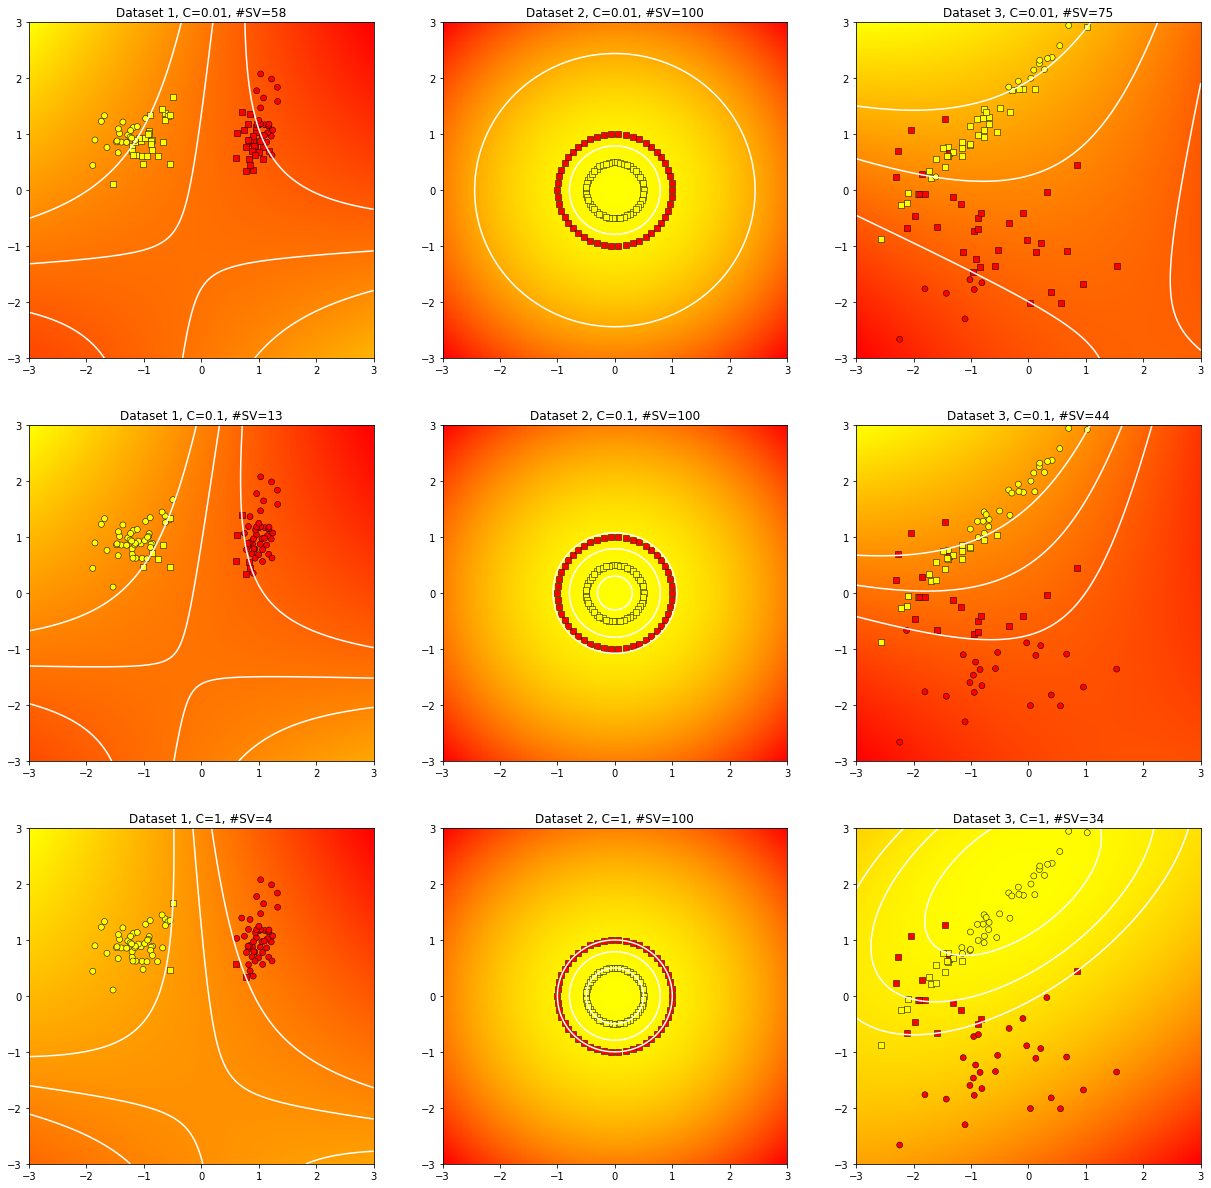

In [20]:
plot_i = 0
C_values = [0.01, 0.1, 1]
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C, transform=append_second_order)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

Awesome! Have a look at SVM from scikit-learn module and how it is used. 

# Problem 3 Written Problems (20 points)

## 3.1 PCA [3 pts]
Suppose we are given inputs $𝑥^𝑖 \in ℝ^𝑛, 𝑖=1,…,𝑚$ and we want to learn a lower-dimensional ($k$-dim) PCA projection of the data onto basis vectors $𝑈=[𝑢^1…𝑢^𝑘]$ where each $𝑢^𝑗 \in ℝ^𝑛$.  Write down the equation for the general $k$-dimensional point $z^𝑖$ obtained by projecting an $n$-dimensional point  $𝑥^𝑖$ onto the $k$ basis vectors.

$$ Sigma = \frac{1}{m} \sum_{i = 1}^{m} (x^{(i)}) (x^{(i)})^T $$
$$ [U, S, V] = svd(Sigma); $$
$$ Ureduce = U(:, 1:K);$$
$$ z = Ureduce' * x; $$

## 3.2 CNNs [8 pts]

Draw a convolutional network with input $x \in R^4$, one hidden layer with 3x1 filters and 2 channels with stride 1, and a fully-connected output layer with one neuron. How many parameters does this network have? Include all biases.

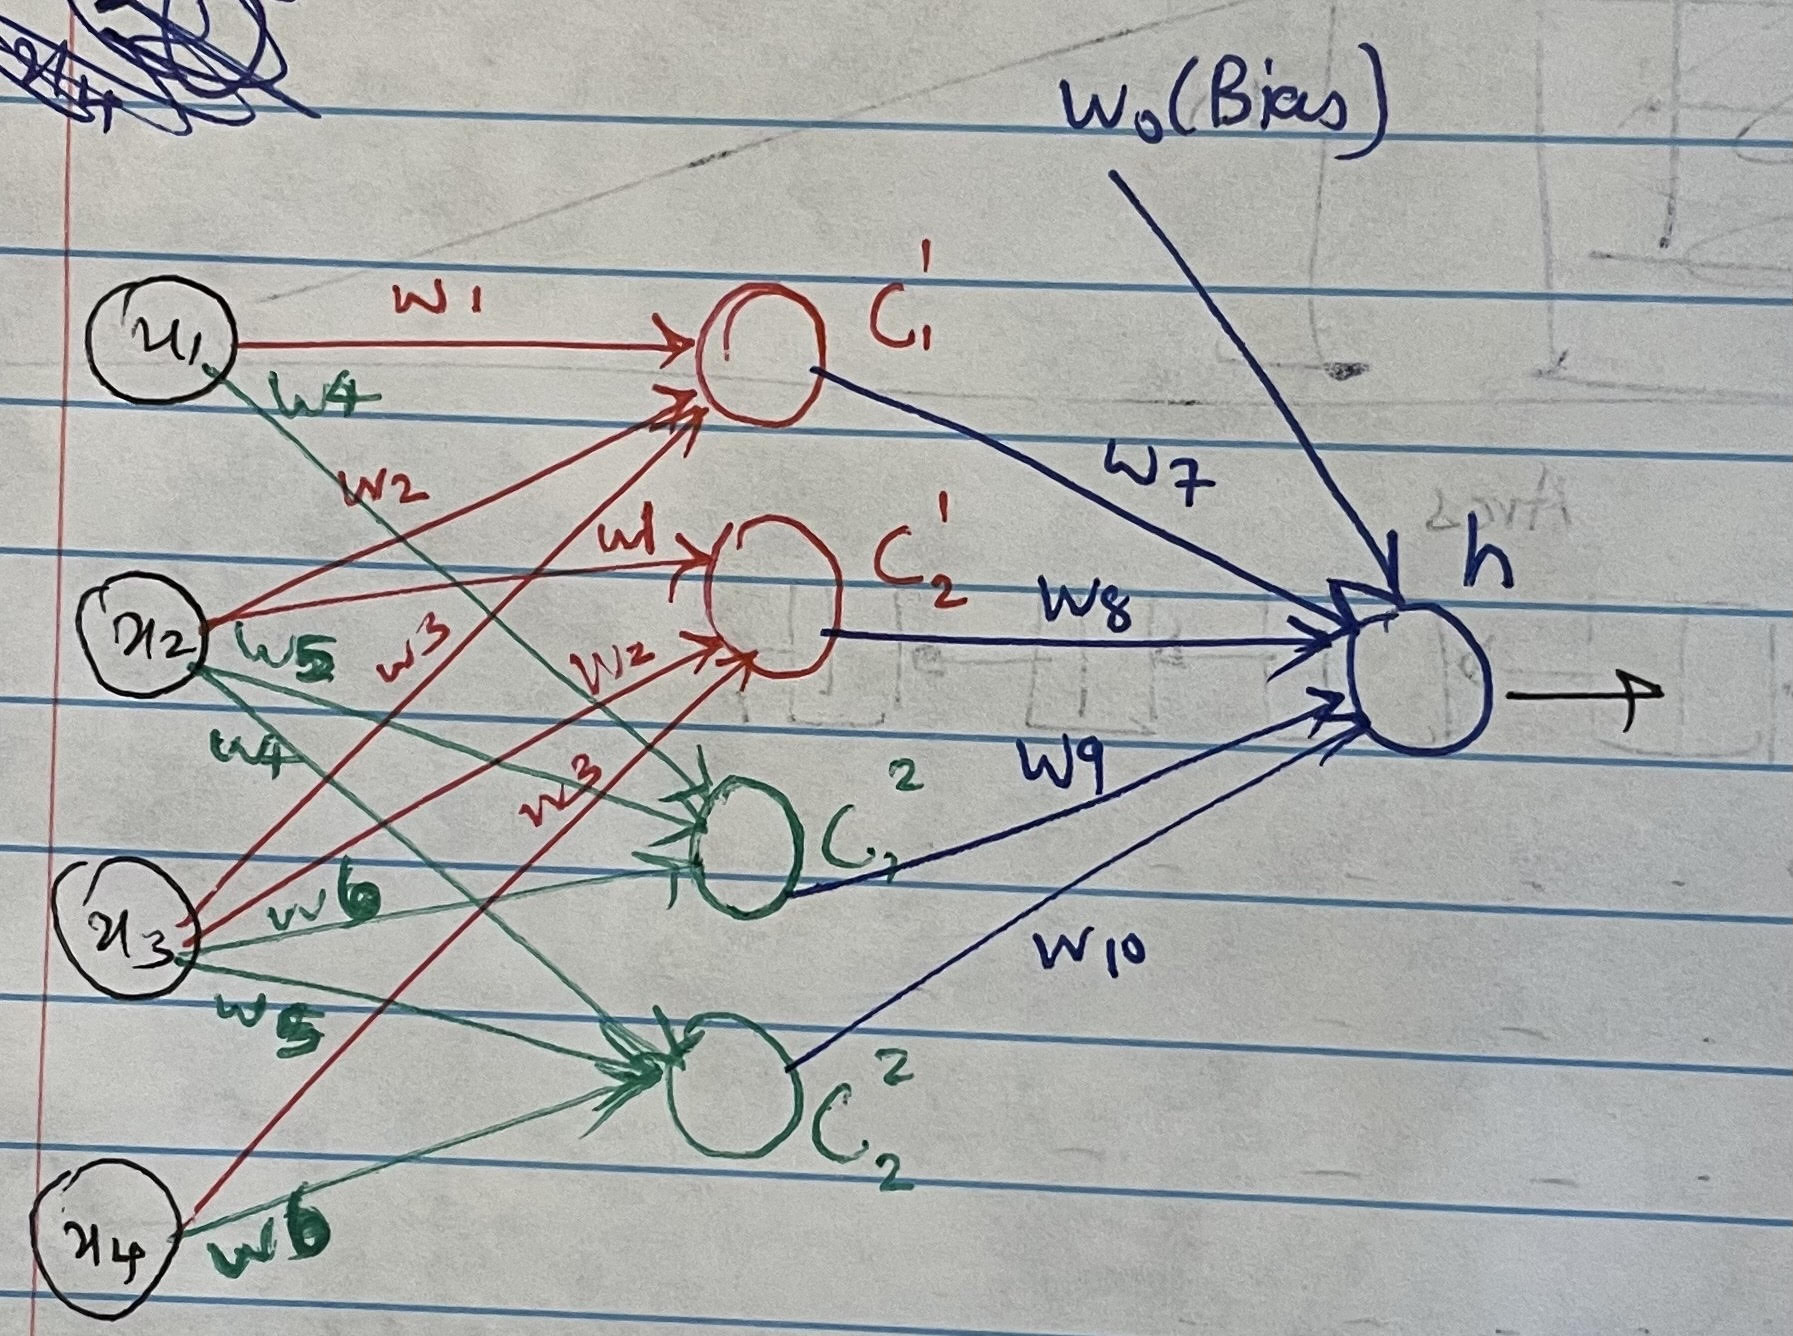

## 3.3 Semi-supervised Learning [3 pts]
What is the difference between co-training and self-training in semi-supervised learning?

Semi-supervised approaches such as Co-training and Self-training have been created to benefit from input information that is contained in unlabeled data.
Self-training trains on one-model(just one model is trained) and is simpler. This model uses its own predictions to artifically label the unlabelled examples and uses these examples in the respective training. However, outliers can adversely affect the result we get from self-training.
Co-training on the other hand trains multiple models(uses more than one different models) and is more robust to outliers. The model diversity is created by through different inputs, different regression methods or different parametrization. Co-training is more computationaly expensive then Self-training.

## 3.4 Explainability [3 pts]
What is the difference between black-box and white-box explainability techniques?

Black-box models have observable input-output relationships but lack clarity around inner workings. Typical of deep learning models which model incredibly complex situations with high non-linearity and interactions between inputs.Despite higher performance, there are several downsides to black-box models:
1)The first downside is simply the lack of explainability to those seeking explanations for why a decision was made.
2)The second downside to black-box models is that there could be a host of unseen problems impacting the output — such as overfit, spurious correlations, or "garbage in / garbage out" — that are impossible to catch due to the lack of understanding around the black-box model’s operations. 

On the other hand, white-box models have observable and understandable behaviors, features, and relationships between influencing variables and the output predictions. However, they are often not as performant as black-box models; i.e. they have lower accuracy but higher explainability.

## 3.5 Domain Adaptation [3 pts]
Assume you have data consisting of images of the road in the summer in which you have labeled road signs, and images of the road in the winter in which you have no labels for the road signs. Explain one way you could label the road signs in the images taken in winter with a decent accuracy.

Use semi-supervised training where unlabeled data, when used in conjunction with a small amount of labeled data, can produce considerable improvement in learning accuracy.